In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laplace-dataset/mnist_net_checkpoint.pth
/kaggle/input/laplace-dataset/subnet_mask_indices.pt


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torch.nn import MSELoss, CrossEntropyLoss

from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.nn import MSELoss, CrossEntropyLoss
from torch.distributions.multivariate_normal import _precision_to_scale_tril


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

Using device cuda:0


100%|██████████| 9912422/9912422 [00:00<00:00, 239875556.73it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43778711.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73868787.88it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18040273.45it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
#         self.pool = nn.AvgPool2d(kernel_size=2)
#         self.fc1 = nn.Linear(4 * 13 * 13, 16) 
#         self.fc2 = nn.Linear(16, 10)

#     def forward(self, x):
#         x = self.pool(torch.tanh(self.conv1(x)))
#         x = x.view(-1, 4 * 13 * 13)
#         x = torch.tanh(self.fc1(x))
#         x = torch.softmax(self.fc2(x), dim=1)
#         return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

In [6]:
# Initialize the network
net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# model parameters
sum(p.numel() for p in net.parameters())

214538

In [7]:
# Train the network for 3 epochs
for epoch in range(1):
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i + 1) % 10000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch + 1, 3, i + 1, len(train_loader), loss.item()))

KeyboardInterrupt: 

In [8]:
# Evaluate the network on the test set
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy: {}%'.format((correct / total) * 100))

# Save the model
torch.save(net.state_dict(), './mnist_net.pth')

# Load the model
model = Net().to(device)
model.load_state_dict(torch.load('./mnist_net.pth'))

Test Accuracy: 65.14999999999999%


<All keys matched successfully>

In [9]:
checkpoint = {
        'epoch': 1,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
torch.save(checkpoint, '/kaggle/working/mnist_net_checkpoint.pth')


In [10]:
import os

def load_checkpoint(filepath, model, optimizer):
    if os.path.isfile(filepath):
        print(f"Loading checkpoint '{filepath}'")
        checkpoint = torch.load(filepath)
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"Loaded checkpoint '{filepath}' (epoch {epoch})")
        return model, optimizer, epoch
    else:
        print(f"No checkpoint found at '{filepath}'")
        return model, optimizer, 0

# Initialize the model and optimizer
net = Net().to(device)
optimizer = optim.Adam(net.parameters())

# Path to your checkpoint
checkpoint_path = '/kaggle/input/laplace-dataset/mnist_net_checkpoint.pth'

# Load the checkpoint
net, optimizer, start_epoch = load_checkpoint(checkpoint_path, net, optimizer)

# Now, you can continue training from the last saved epoch
# for epoch in range(start_epoch, num_epochs):
    # Continue training


Loading checkpoint '/kaggle/input/laplace-dataset/mnist_net_checkpoint.pth'
Loaded checkpoint '/kaggle/input/laplace-dataset/mnist_net_checkpoint.pth' (epoch 1)


In [11]:
from torch.nn.utils import parameters_to_vector
from copy import deepcopy
_model = deepcopy(net)
_model.train()
device = next(_model.parameters()).device
device
def _param_vector(model):
    return parameters_to_vector(model.parameters()).detach()
mean = torch.zeros_like(_param_vector(_model))
sq_mean = torch.zeros_like(_param_vector(_model))
n_snapshots = 0
n_snapshots_total=2
snapshot_freq=1
lr=0.01
momentum=0.9
weight_decay=3e-4
min_var=1e-30
optimizer = torch.optim.SGD(
    _model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
n_epochs = snapshot_freq * n_snapshots_total

In [12]:
for epoch in range(n_epochs):
    print("epoch ", epoch)
    i = 0
    for inputs, targets in train_loader:
        i=i+1
        if(i%10000 == 0):
            print(i)
        
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        loss = criterion(_model(inputs), targets)
        loss.backward()
        optimizer.step()

    if epoch % snapshot_freq == 0:
        old_fac, new_fac = n_snapshots / (n_snapshots + 1), 1 / (n_snapshots + 1)
        mean = mean * old_fac + _param_vector(_model) * new_fac
        sq_mean = sq_mean * old_fac + _param_vector(_model) ** 2 * new_fac
        n_snapshots += 1

epoch  0


KeyboardInterrupt: 

In [13]:
param_variances = torch.clamp(sq_mean - mean ** 2, min_var)
_n_params_subnet = 300
idx = torch.argsort(param_variances, descending=True)[:_n_params_subnet]
idx = idx.sort()[0]
parameter_vector = parameters_to_vector(net.parameters()).detach()
subnet_mask = torch.zeros_like(parameter_vector).bool()
subnet_mask[idx] = 1
subnet_mask_indices = subnet_mask.nonzero(as_tuple=True)[0]

In [14]:
subnet_mask_indices

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [15]:
torch.save(subnet_mask_indices, 'subnet_mask_indices.pt')

In [16]:
subnet_mask_indices_loaded = torch.load('/kaggle/input/laplace-dataset/subnet_mask_indices.pt')

subnet_mask_indices_cuda = subnet_mask_indices_loaded.to(device)

In [17]:
params_dict = {k: v for k, v in net.named_parameters() if v.requires_grad}
buffers_dict = {k: v for k, v in net.named_buffers()}

In [18]:
net = net.to(device)
params_dict = {key: value.to(device) for key, value in params_dict.items()}
buffers_dict = {key: value.to(device) for key, value in buffers_dict.items()}
# params_dict = {key: value.detach() for key, value in params_dict.items()}
# buffers_dict = {key: value.detach() for key, value in buffers_dict.items()}
n_params = len(parameters_to_vector(net.parameters()).detach())
H = torch.zeros(_n_params_subnet, _n_params_subnet, device=device)
loss = 0
n_data = 0
net.eval()
mean = parameters_to_vector(net.parameters())
X, _ = next(iter(train_loader))
with torch.no_grad():
    try:
        out = net(X[:1].to(device))
    except (TypeError, AttributeError):
        out = net(X.to(device))
n_outputs = out.shape[-1]
setattr(net, 'output_size', n_outputs)

In [19]:
def model_fn_params_only(params_dict, buffers_dict):
    out = torch.func.functional_call(net, (params_dict, buffers_dict), X)
    return out, out

In [20]:
lossfunc = CrossEntropyLoss(reduction='sum')

In [21]:
N = len(train_loader.dataset)
i = 0
for X, y in train_loader:
    i = i+1
    if i%1000 == 0:
        print(i)
        
    net.zero_grad()
    X, y = X.to(device), y.to(device)
    # Js, f = jacobians(X)
    with torch.no_grad():
        Js, f = torch.func.jacrev(model_fn_params_only, has_aux=True)(params_dict, buffers_dict)
        
    Js = [
        j.flatten(start_dim=-p.dim())
        for j, p in zip(Js.values(), params_dict.values())
    ]
    Js = torch.cat(Js, dim=-1)

    Js = Js[:, :, subnet_mask_indices]
    
    
    ps = torch.softmax(f, dim=-1)
    H_lik = torch.diag_embed(ps) - torch.einsum('mk,mc->mck', ps, ps)
    H_batch = torch.einsum('bcp,bck,bkq->pq', Js, H_lik, Js)
    loss_batch = 1. * lossfunc(f, y)
    loss += loss_batch
    H += H_batch
    del Js, f, H_lik, H_batch, ps,loss_batch
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
n_data += N

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000


In [22]:
sigma_noise = 1.
temperature = 1.
sigma_noise = torch.tensor(sigma_noise, device=device)
sigma2 = sigma_noise.square()
_H_factor = 1 / sigma2 / temperature
print(len(H))
prior_precision = 1.
prior_precision_diag = torch.ones(_n_params_subnet, device=device)
posterior_precision = _H_factor * H + torch.diag(prior_precision_diag)
# posterior_precision = torch.diag(prior_precision_diag)
invsqrt_precision = _precision_to_scale_tril
posterior_scale = invsqrt_precision(posterior_precision)
scale = posterior_scale
posterior_covariance = scale @ scale.T
print(posterior_covariance.shape)


300
torch.Size([300, 300])


In [23]:
data_iter = iter(train_loader)
x, label_var = next(data_iter)

In [24]:
def model_fn_params_only_1(params_dict, buffers_dict):
    out = torch.func.functional_call(net, (params_dict, buffers_dict), x)
    return out, out

In [25]:
import matplotlib.pyplot as plt
data_iter = iter(test_loader)

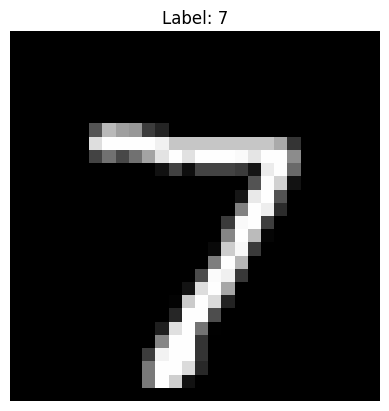

In [26]:
x, label_var = next(data_iter)
x = x[0]
label = label_var[0]

image = x.view(28, 28)

plt.imshow(image, cmap='gray')
plt.title('Label: {}'.format(label))
plt.axis('off')  # Hide axes
plt.show()


x = x.to(device)

In [27]:
with torch.no_grad():
    Js, f_mu = torch.func.jacrev(model_fn_params_only_1, has_aux=True)(params_dict, buffers_dict)

Js = [
    j.flatten(start_dim=-p.dim())
    for j, p in zip(Js.values(), params_dict.values())
]
Js = torch.cat(Js, dim=-1)

Js = Js[:, :, subnet_mask_indices]

Js = Js.squeeze(0)
f_var = torch.einsum('np,pq,mq->nm', Js, posterior_covariance, Js)
f_var = f_var.unsqueeze(0)
kappa = 1 / torch.sqrt(1. + np.pi / 8 * f_var.diagonal(dim1=1, dim2=2))
final_ppd = torch.softmax(kappa * f_mu, dim=-1)
print(final_ppd)

tensor([[0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.2320, 0.0853,
         0.0853]], device='cuda:0')
